# Matched Filter Pipeline Demo (EnMAP)

This notebook runs the CH$\_4$ detection pipeline on an EnMAP L1B scene to illustrate how the matched filter, LUT-derived targets, and propagated noise cubes generate concentration/uncertainty rasters.

**Pipeline stages**
1. Bootstrap the repository context so the helper modules in `scripts/` can be imported from the notebook.
2. Declare the scene assets, spectral window, and k-means configuration that parameterise the matched filter.
3. Execute `enmap_pipeline.ch4_detection_enmap`, which handles radiance calibration, background statistics, LUT target synthesis, and the matched-filter solve $w = \Sigma^{-1}(t-\mu)$ followed by $\Delta X = w^\top (L-\mu)$.
4. Load the RGB, concentration, and $\sigma_{RMN}$ rasters to interpret plume structure versus instrument noise.


## 1. Bootstrap repository context
Add the repository root to `PYTHONPATH`, locate the `scripts/` directory, and emit the resolved paths. This guarantees that the remainder of the notebook reuses the exact same pipeline code as the CLI, avoiding environment drift between experiments and notebook runs.


In [17]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT
while not (REPO_ROOT / 'scripts').exists() and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent
if not (REPO_ROOT / 'scripts').exists():
    raise RuntimeError('Could not locate repository root containing scripts directory.')

os.environ.setdefault('PYTHONPATH', str(REPO_ROOT))
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

print(f'Notebook root: {NOTEBOOK_ROOT}')
print(f'Repository root: {REPO_ROOT}')

Notebook root: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks
Repository root: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas


## 2. Scene configuration and assumptions
The configuration dictionary pins the VNIR/SWIR GeoTIFFs, metadata XML, LUT file, and precomputed SNR reference. `min_wavelength`/`max_wavelength` restrict the matched filter to absorption features (here 2.1-2.45 um), while `k` controls how many k-means clusters are used to model background covariance. The LUT mixes simulated spectra at increasing columns (0-64,000 ppm·m) so the pipeline can interpolate a target signature that matches the scene's solar zenith angle, water vapour, and elevation.


In [18]:
SENSOR = 'enmap'

CONFIG = {
    'vnir': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Turkmenistan_20221002/20221002T074833/L1B_20221002T074833Z_002_V010501_20241110T222710Z/ENMAP01-____L1B-DT0000004147_20221002T074833Z_002_V010501_20241110T222710Z-SPECTRAL_IMAGE_VNIR.TIF'),
    'swir': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Turkmenistan_20221002/20221002T074833/L1B_20221002T074833Z_002_V010501_20241110T222710Z/ENMAP01-____L1B-DT0000004147_20221002T074833Z_002_V010501_20241110T222710Z-SPECTRAL_IMAGE_SWIR.TIF'),
    'metadata': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Turkmenistan_20221002/20221002T074833/L1B_20221002T074833Z_002_V010501_20241110T222710Z/ENMAP01-____L1B-DT0000004147_20221002T074833Z_002_V010501_20241110T222710Z-METADATA.XML'),
    'lut': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/LUTs/CH4_lut.hdf5'),
    'snr_reference': REPO_ROOT / 'notebooks' / 'outputs' / 'enmap' / 'L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z' / 'snr_reference_columnwise.npz',
    'output_dir': NOTEBOOK_ROOT / 'outputs' / 'pipeline_demo' / 'enmap',
    'min_wavelength': 2100.0,
    'max_wavelength': 2450.0,
    'k': 1,
}

CONFIG['output_dir'].mkdir(parents=True, exist_ok=True)
CONFIG

{'vnir': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Turkmenistan_20221002/20221002T074833/L1B_20221002T074833Z_002_V010501_20241110T222710Z/ENMAP01-____L1B-DT0000004147_20221002T074833Z_002_V010501_20241110T222710Z-SPECTRAL_IMAGE_VNIR.TIF'),
 'swir': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Turkmenistan_20221002/20221002T074833/L1B_20221002T074833Z_002_V010501_20241110T222710Z/ENMAP01-____L1B-DT0000004147_20221002T074833Z_002_V010501_20241110T222710Z-SPECTRAL_IMAGE_SWIR.TIF'),
 'metadata': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Turkmenistan_20221002/20221002T074833/L1B_20221002T074833Z_002_V010501_20241110T222710Z/ENMAP01-____L1B-DT0000004147_20221002T074833Z_002_V010501_20241110T222710Z-METADATA.XML'),
 'lut': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapi

## 3. Run the matched-filter pipeline
`enmap_pipeline.ch4_detection_enmap` performs the operational workflow: destriping/equalisation, k-means clustering, covariance estimation, LUT-based target synthesis, and the matched filter solve. The filter weights are derived from $w = \Sigma^{-1}(t-\mu)$ and applied column-wise to radiance residuals to obtain path-integrated enhancements. The function also propagates the SNR reference to produce $\sigma_{RMN}$, assuming temporally stable detector noise and Gaussian statistics.


In [19]:
from scripts.pipelines import enmap_pipeline

enmap_pipeline.ch4_detection_enmap(
    vnir_file=str(CONFIG['vnir']),
    swir_file=str(CONFIG['swir']),
    metadata_file=str(CONFIG['metadata']),
    lut_file=str(CONFIG['lut']),
    output_dir=str(CONFIG['output_dir']),
    k=CONFIG['k'],
    min_wavelength=CONFIG['min_wavelength'],
    max_wavelength=CONFIG['max_wavelength'],
    snr_reference_path=str(CONFIG['snr_reference'])
)
print('Pipeline run complete.')

Sun Zenith Angle (degrees): 43.0
Mean Water Vapor (g/cm^2): 1.638
Mean Ground Elevation (m): -15.071
Report di elaborazione EnMAP generato in: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/enmap/processing_report.txt
Pipeline run complete.


## 4. Load and interpret retrieval outputs
The helper routines locate the most recent RGB/composite/uncertainty rasters inside `output_dir`, read them with GDAL, and normalise the RGB channels for display. The concentration panel shows $\Delta X$ (ppm·m) constrained to 0-8,000 to highlight plume cores, whereas the uncertainty panel visualises $\sigma_{RMN}$ (instrument noise propagated through the matched filter) in ppm·m. Comparing both maps helps distinguish signal-dominated regions (high enhancement with low $\sigma_{RMN}$) from noise-limited artefacts.


RGB: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/enmap/L1B_DT0000004147_002_20221002T074833Z_20221002T074837Z_RGB.tif
Concentration: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/enmap/L1B_DT0000004147_002_20221002T074833Z_20221002T074837Z_MF.tif
Uncertainty: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/pipeline_demo/enmap/L1B_DT0000004147_002_20221002T074833Z_20221002T074837Z_MF_uncertainty.tif


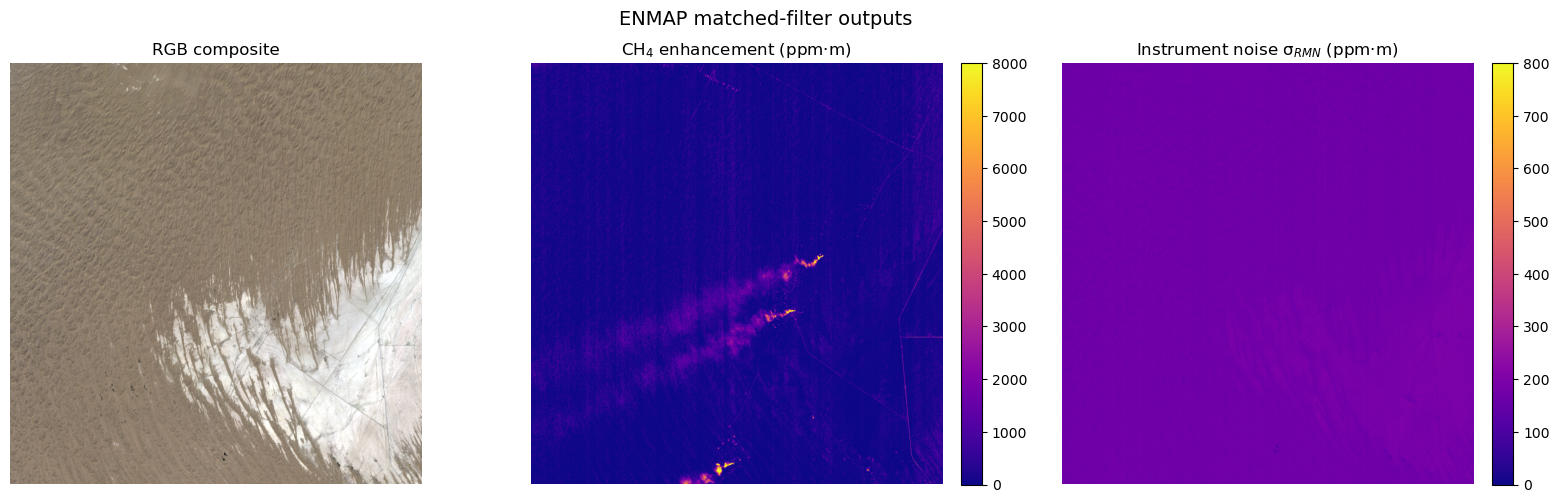

In [20]:
def _find_output(pattern: str):
    matches = sorted(CONFIG['output_dir'].glob(pattern))
    if not matches:
        raise FileNotFoundError(f"No files matching {pattern} found in {CONFIG['output_dir']}")
    return matches[-1]

def _read_raster(path: Path):
    ds = gdal.Open(str(path))
    if ds is None:
        raise RuntimeError(f'Failed to open raster: {path}')
    arr = ds.ReadAsArray().astype(np.float32)
    ds = None
    return arr

rgb_path = _find_output('*_RGB.tif')
conc_path = _find_output('*_MF.tif')
unc_path = _find_output('*_MF_uncertainty.tif')

print('RGB:', rgb_path)
print('Concentration:', conc_path)
print('Uncertainty:', unc_path)

rgb = _read_raster(rgb_path)
concentration = _read_raster(conc_path)
uncertainty = _read_raster(unc_path)

if rgb.ndim == 3:
    rgb_img = np.transpose(rgb, (1, 2, 0))
else:
    rgb_img = rgb

def _normalize_rgb(arr: np.ndarray) -> np.ndarray:
    high = np.quantile(arr, 0.995, axis=(0, 1), keepdims=True)
    high = np.clip(high, 1e-3, None)
    arr = np.clip(arr, 0, high)
    arr = arr / high
    return np.clip(arr, 0, 1)

rgb_disp = _normalize_rgb(rgb_img.astype(np.float32))

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].imshow(rgb_disp)
axes[0].set_title('RGB composite')
axes[0].axis('off')

im1 = axes[1].imshow(concentration, cmap='plasma', vmin=0, vmax=8000)
axes[1].set_title('CH$_4$ enhancement (ppm·m)')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(uncertainty, cmap='plasma', vmin=0, vmax=800)
axes[2].set_title('Instrument noise σ$_{RMN}$ (ppm·m)')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

for ax in axes[1:]:
    ax.axis('off')

fig.suptitle(SENSOR.upper() + ' matched-filter outputs', fontsize=14)
plt.tight_layout()
plt.show()